In [1]:
from typing import Any, Callable, List, Optional, Type, Union, Tuple
from torch import Tensor

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms


import matplotlib.pyplot as plt

from models.resnets import resnet
from utils.network_utils import count_parameters, count_FLOPS, calculate_storage_in_mb

## Prepare dataset

In [2]:
# import dataset from torch
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


### Dataloader

In [3]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

### Preview images

In [4]:
def imshow_image(img) -> None:
    plt.imshow(img.cpu().permute(1, 2, 0))
    plt.axis("off")


def show_cifar_images(
    grid_size: Tuple[int, int],
    show_labels: bool = True,
    dataset: str = None,
    preds: List[int] = None,
):
    """
    Show a grid of images from CIFAR10 dataset
    """
    if preds is not None:
        assert len(preds) == grid_size[0] * grid_size[1]
    if dataset is None:
        dataset = testset
    n1, n2 = grid_size
    plt.subplots(n1, n2, figsize=(n2 * 1.5, n1 * 1.5))
    for i in range(n2):
        for j in range(n1):
            idx = i * grid_size[0] + j
            img, label = dataset[idx]
            img = img / 2 + 0.5  # unnormalize
            plt.subplot(n1, n2, idx + 1)
            imshow_image(img)
            if show_labels:
                plt.title(classes[label])
            if preds is not None:
                if label != preds[idx]:
                    color = "red"
                plt.title(f"{classes[label]}-{classes[preds[idx]]}", color=color)
    plt.tight_layout()
    plt.show()

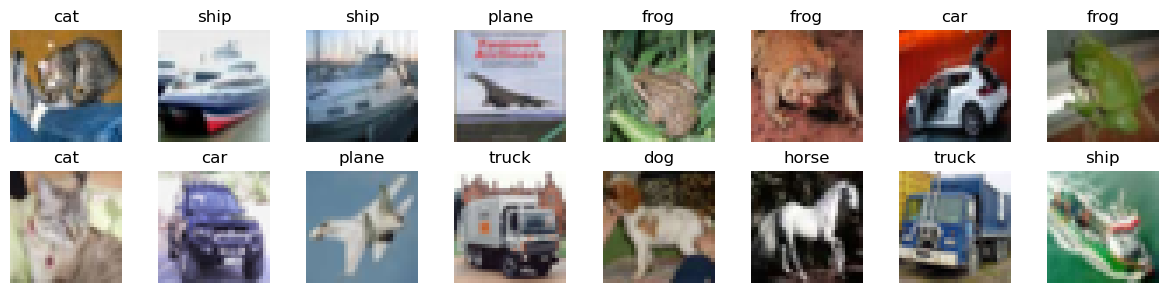

In [5]:
show_cifar_images((2, 8), show_labels=True, dataset=testset)
# to show images with predictions:
# show_cifar_images((2, 8), show_labels=True, dataset=testset, preds=preds)

## ResNet

In [6]:
def compute_expected_layers(model: nn.Module) -> int:
    """
    Compute the expected depth with stochastic depth
    """
    sd_config = model.sd_config
    num_layers = sum([1 - p for p in sd_config.probs])
    # multiply by 2 because conv + bn, +2 for first conv and bn
    num_layers = num_layers * 2 + 2
    return num_layers

In [8]:
resnet18 = resnet("resnet18", num_classes=10, dropout_mode="classifier", dropout_p=0.3)

# load resnet18 pretrained on ImageNet
# resnet18_torch = torchvision.models.resnet.resnet18(num_classes=10)

print(f"Number of parameters: {count_parameters(resnet18, print_table=False)/1e6 :.3f} M")
print(f"Parameter in MB: {calculate_storage_in_mb(resnet18):.3f}")
print(f"Number of expected layers: {compute_expected_layers(resnet18)}")
# print(f"Number of FLOPS: {count_FLOPS(resnet18, input_dim=(32, 32))/1e9:.3f} GFLOPS")

Number of parameters: 11.182 M
Buffer size: 0.037 MB
Parameter in MB: 42.691
Number of expected layers: 18.0


In [ ]:
resnet18